# Estimating the Background

In this workbook we will investigate different methods for estimating the background for a test SNR. We will trial a simple constant background method, and a more complicated estimation method. We will compare the fit results between the two methods.

In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import wcs
from astropy.io import fits
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column,vstack
from astropy.io.votable import writeto as writetoVO
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from scipy import ndimage, misc


# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg,calc_img_bkg_rms
import snrfit

# For downlaoding images.
import gleam_client

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
def background_estimator(img_arr,constants,mask):
    """
    Estimate Background.
    
    Parameters:
    ----------
    img_arr : numpy array of image
    constants :[boxsize,filtersize,sigma]
    mask : mask for image
    Returns:
    ----------
    percent : float
        percentage of source removed
    """
    boxsize = (constants[0],constants[0])
    filtersize = (constants[1],constants[1])
    sigma = constants[2]
    sigma_clip = SigmaClip(sigma=sigma)

    bkg_estimator = MedianBackground(sigma_clip)

    mask = ~mask
    try:
        bkg = Background2D(img_arr, boxsize,mask=mask, filter_size=filtersize,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, exclude_percentile=10)
        img_bkg = bkg.background
    except ValueError:
        #will run this for uniform background
        img_bkg = np.zeros((np.shape(img_arr)))

    rms = np.std(img_arr[~mask])

    return img_bkg, rms

RA : 225.7083, DEC : -41.9333
Major = 30.0 [arcmin], Minor = 30.0 [arcmin]
Angular size = 1.0 [degrees]


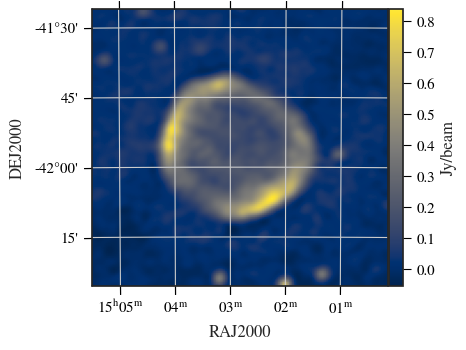

Image shape (129,129)
dx = 7.697e-03 [deg]
Image pixel center = (64.667, 64.667)
Determined the RA and DEC for the entire pixel grid.
Calculated the angular distance from each pixel to the image centre.
30.0
rms = 2.146e-02 [Jy/beam]
img_bkg = 1.550e-02 [Jy/beam]


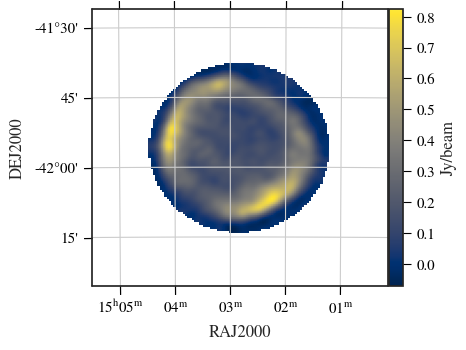

In [2]:
# Parent directory.
parent_path = '../'

# Catalogue filename.
cat_filename = 'Green-167MHz-filtered-dec+30.fits'

# Opening fits table.
cat = fits.open(parent_path + 'data/' + cat_filename)

# Creating table object.
t_SNR = Table(cat[1].data)

# SNR ID's
SNR_IDs = np.array(t_SNR['recno']).astype('int')

# Getting the RA and Dec. # These may be different for different catalogues.
RA_vec = np.array(t_SNR['_RAJ2000'])
DEC_vec = np.array(t_SNR['_DEJ2000'])
SI_vec = np.array(t_SNR['Sp-Index']) # Spectral index vector

t_SN1006 = t_SNR[t_SNR['SNR'] == 'G327.6+14.6']

RA_SN1006 = float(RA_vec[t_SNR['SNR'] == 'G327.6+14.6'])
DEC_SN1006 = float(DEC_vec[t_SNR['SNR'] == 'G327.6+14.6'])

## Looping through each SNR. This may take sometime. 
Major = float(t_SNR['MajDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]
Minor = float(t_SNR['MinDiam'][t_SNR['SNR'] == 'G327.6+14.6']) #[arcmin]

# Calculating the max angular size of the ith SNR image.
ang_size = 2*Major/60 # [Degrees].

print('RA : %s, DEC : %s' % (RA_SN1006,DEC_SN1006))
print('Major = %s [arcmin], Minor = %s [arcmin]' % (Major,Minor))
print('Angular size = %s [degrees]' % ang_size)

#%%capture

# Get SNR image from GLEAM using gleam_client.
freq_range = '170-231'

filename = 'RA%5.2f_DEC%5.2f_%sMHz.fits' % (RA_SN1006,DEC_SN1006,freq_range)

# For now download to the current working directory, but you can change this to whatever you like. Typically I like to have this separate from the main directory. 
download_dir = '../data/'

if os.path.isfile(download_dir + filename) == False:
    # Tests to see if the file exists or not.
    gleam_client.vo_get(RA_SN1006, DEC_SN1006, ang_size, freq=[freq_range], 
                proj_opt='SIN', download_dir=download_dir,file_name_func=filename)

else:
    pass

warnings.filterwarnings("ignore")
with fits.open(download_dir+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]

w = WCS(header).celestial

snrfit.astro_plot_2D(img_arr, w, figsize=(7.5,6),scale=0.6)

X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

# The RA and DEC arrays, can use to determine angular mask.
RA_arr, DEC_arr = w.wcs_pix2world(xx_pix + 1, yy_pix + 1, 1)
print('Determined the RA and DEC for the entire pixel grid.')

# Calculating the angular distance from the image centre to each pixel.
theta_dist = np.degrees(snrfit.great_circle_dist(np.radians(DEC_SN1006),
                    np.radians(DEC_arr),np.radians(RA_SN1006),np.radians(RA_arr)))
print('Calculated the angular distance from each pixel to the image centre.')

print(Major)

# Temporary index array. Used for masking the image. Size padded.
theta_ind_arr_ge = theta_dist >= 0.5*Major/60 + 7.5*dx

img_bkg,rms = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge)

print('rms = %5.3e [Jy/beam]' % rms)
print('img_bkg = %5.3e [Jy/beam]' % img_bkg)


img_nu = np.ones(img_arr.shape)*img_arr - img_bkg
img_nu[theta_ind_arr_ge] = np.nan

snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)



### Testing the SigmaClip function.

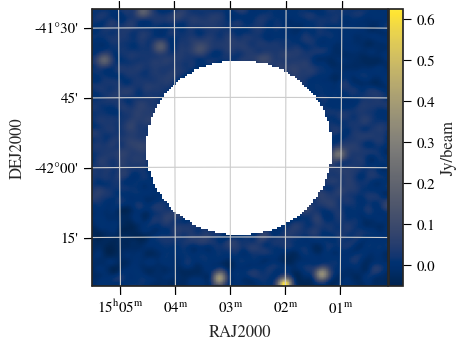

In [3]:
img_not_cutout = np.ones(img_arr.shape)*img_arr
img_not_cutout[theta_ind_arr_ge == False] = np.nan

snrfit.astro_plot_2D(img_not_cutout, w, figsize=(7.5,6),scale=0.6)

sigclip = SigmaClip(sigma=2.7,cenfunc='median')
#sigclip = SigmaClip(sigma_lower=2,sigma_upper=3,cenfunc='median')

img_clipped = sigclip(img_not_cutout)

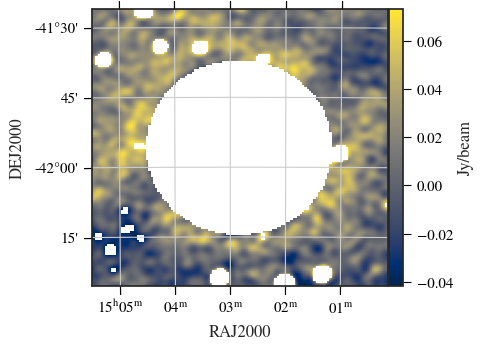

In [4]:
snrfit.astro_plot_2D(img_clipped, w, figsize=(7.5,6),scale=0.6)

In [5]:
#bkg = Background2D(img_clipped, filter_size=(3, 3))
bkg = Background2D(img_clipped, 3, filter_size=(3, 3))

#bkg = Background2D(img_clipped, (50, 50), filter_size=(3, 3),
#                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

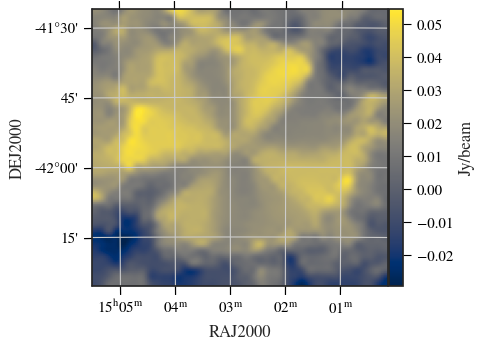

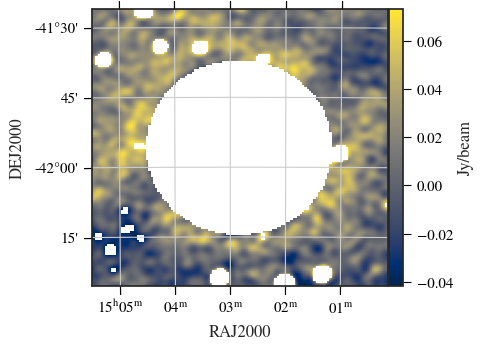

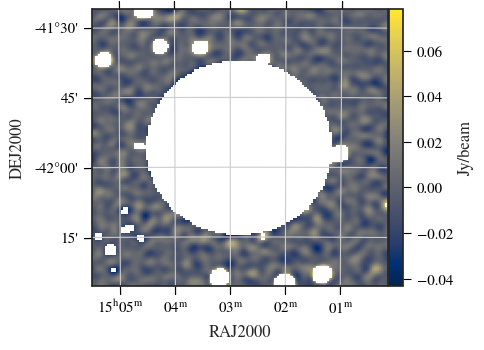

In [6]:
img_clipped_nu = img_clipped - bkg.background
img_nu_nu = img_nu - bkg.background



img_clipped_nu[theta_ind_arr_ge == False] = np.nan
img_nu_nu[theta_ind_arr_ge] = np.nan
snrfit.astro_plot_2D(bkg.background, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(img_clipped, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(img_clipped_nu, w, figsize=(7.5,6),scale=0.6)

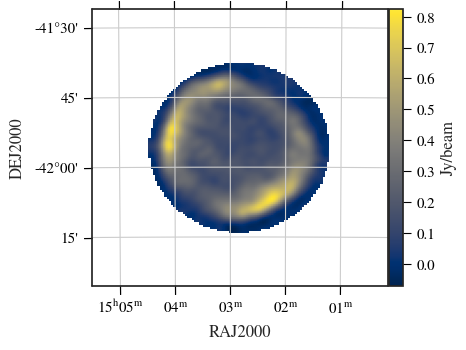

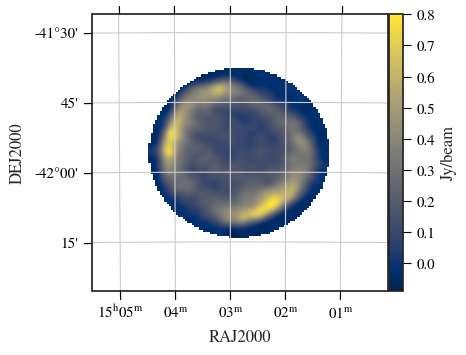

In [7]:
snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(img_nu_nu, w, figsize=(7.5,6),scale=0.6)

Min sigma =  2.042 [pix]
Maximum sigma = 27.587
Performing peak detection with 1.073e-02 threshold.
Detected an initial 22 peaks.


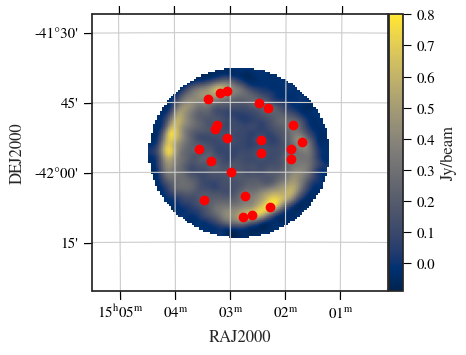

2.042350888813898 2.042350888813898
[3.02778254 4.85524263 5.07759939 4.9296119  2.97122726] 10.671374678671786 2.042350888813901
[7.51624868 2.22289483 2.14900158 2.04235089 8.08573455] 12.201627728043409 2.0423508888138984


In [8]:
a_psf = header['BMAJ'] #[deg]
b_psf = header['BMIN'] #[deg]
PA_psf = header['BPA'] #[deg]

# Easier than having lots of keywords arguments.
peak_constants = (a_psf,Major,dx,rms)

# Creating new coord object. 
coord_log_nu = snrfit.determine_peaks_bkg(img_nu_nu,peak_constants,maj_fac=1,num_sigma=20,
            thresh_fac=0.5,overlap=1,log_cond=False)

snrfit.astro_plot_2D(img_nu_nu, w, figsize=(7.5,6),scatter_points=coord_log_nu,scale=0.6)

data = img_nu_nu[theta_ind_arr_ge == False]
xx = xx_pix[theta_ind_arr_ge == False]
yy = yy_pix[theta_ind_arr_ge == False]

maj_min = (Major,Minor)

# Parameter list is formatted like:
# p = [amplitude,x0,y0,sigx,sigy,theta_PA]

# Number of Gaussians is equal to the number of peaks. 
N_gauss = len(coord_log_nu)
N_params = 6 # 2D Gaussian parameters.

# The guess parameter array.
pguess = np.zeros((N_gauss,N_params))

# This is where we make our intellegent guess based on the peak positions,
# blob sizes and image pixel values.
# Assigning the row values for each column.
pguess[:,0] = coord_log_nu[:,3] # Amplitude
pguess[:,1] = coord_log_nu[:,1] # x0
pguess[:,2] = coord_log_nu[:,0] # y0

pguess[:,3] = coord_log_nu[:,2] # sigx
pguess[:,4] = coord_log_nu[:,2] # sigy


#constants = [2*Major,2*Minor,dx,a_psf,a_psf,0]
constants = [Major,Minor,dx,a_psf,a_psf,0]

popt,perr = SNR_Gauss_fit(xx,yy,data,coord_log_nu,constants,maj_frac=0.5)


# Calculating the model image. 
zz = NGaussian2D((xx_pix,yy_pix),popt.ravel(),fit=False).reshape(X, Y)
 
# Printing the Gaussian sizes.
p_sigx = popt[:,3]
p_sigy = popt[:,4]

print(p_sigx[:5],np.max(p_sigx),np.min(p_sigx))
print(p_sigy[:5],np.max(p_sigy),np.min(p_sigy))


# Calculating the residual image.
resid_img = img_nu_nu - zz

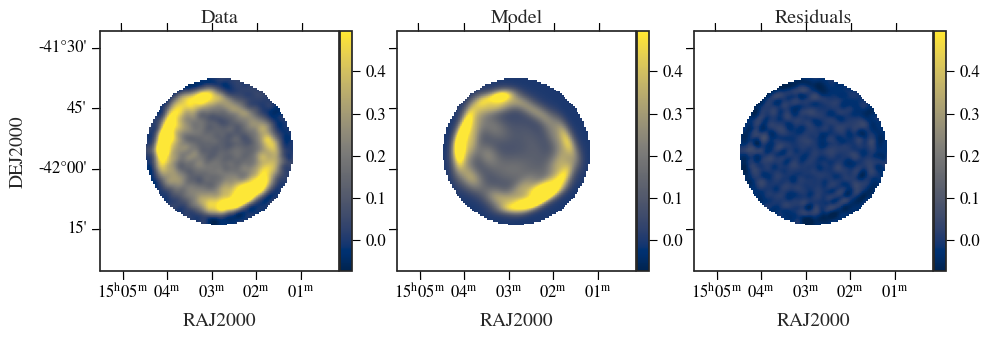

rms = 2.146e-02 [Jy/beam]
residual std = 2.380e-02 [Jy/beam]


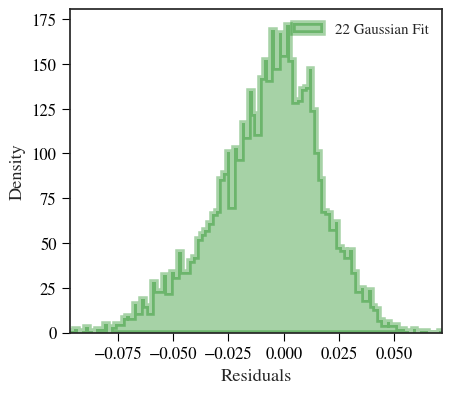

In [9]:

zz[theta_ind_arr_ge] = np.nan
snrfit.point_plot(zz,img_nu,resid_img,w,scale=0.6)

print('rms = %5.3e [Jy/beam]' % rms)
print('residual std = %5.3e [Jy/beam]' % np.std(resid_img[theta_ind_arr_ge == False]))
snrfit.hist_residual_plot(resid_img[theta_ind_arr_ge == False],bins=100,N_peaks=len(coord_log_nu),scale=0.6)